In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as feat
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import linregress
from shapely.geometry import mapping
import cartopy.io.shapereader as shpr
from cartopy.mpl.geoaxes import GeoAxes
# import cartopy.io.img_tiles as cimgt
from rasterio.windows import from_bounds
from matplotlib.patches import ConnectionPatch
from rasterio.features import geometry_mask
from matplotlib.patheffects import Stroke, Normal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.weight'] = 'bold'
# %matplotlib inline

In [3]:
def add_map(ax, b = 0, t=0, l = 0, r = 0, fontsize=None, fontweight=None):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.3, 
                         linestyle='-', draw_labels=True)
    gl.bottom_labels = b
    gl.left_labels = l
    gl.top_labels = t
    gl.right_labels = r
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if not fontsize:
        fontsize = 12
    if not fontweight:
        fontweight = 'normal'
    gl.xlabel_style = {'size': fontsize, 'color': 'k', 'weight': fontweight}
    gl.ylabel_style = {'size': fontsize, 'color': 'k', 'weight': fontweight}
#     ax.add_feature(feat.STATES.with_scale('10m'))

In [4]:
def zebra_frame(self, lw=3, colors= None, crs=None,
                zorder=None, use_ticks = False,
                use_extent = True, nrow=8, ncolumn=8):
    """
    Author: Chang Liao (changliao1025@outlook.com)
    Automatically add zebra frame to the axes, in the given coordinate
    system, at draw time.

    Parameters
    ----------
    lw: optional
        The line width of the zebra frame.
    colors: optional
        The colors of the zebra frame, a list of two colors.
    crs: optional
        The :class:`cartopy._crs.CRS` defining the coordinate system in
        which gridlines are drawn.
        Defaults to :class:`cartopy.crs.PlateCarree`.
    zorder: optional
        The zorder of the zebra frame.
    use_ticks: optional
        If True, the zebra frame will follow the ticks.
    use_extent: optional
        If True, the zebra frame will follow the map extent.
    Returns
    -------
    Notes
    -----
    Details: https://github.com/SciTools/cartopy/issues/1830

    """
    # Alternate black and white line segments
    if colors is None:
        bws = itertools.cycle(["k", "w"])
    else:
        if len(colors) != 2:
            raise ValueError("The colors must be a list of two colors.")
        for color in colors:
            if not matplotlib.colors.is_color_like(color):
                raise ValueError(f"{color} is not a valid color.")
        bws = itertools.cycle(colors)

    self.spines["geo"].set_visible(False)

    if use_extent is True:
        left, right, bottom, top = self.get_extent()
        crs_map = self.projection
        dx = right - left
        dy = top - bottom
        xticks = np.arange(left, right+dx/(ncolumn+1), dx/ncolumn)
        yticks = np.arange(bottom, top+dy/(nrow+1), dy/nrow)
    else:
        if use_ticks is True:
            crs_map = crs
            xticks = sorted([*self.get_xticks()])
            xticks = np.unique(np.array(xticks))
            yticks = sorted([*self.get_yticks()])
            yticks = np.unique(np.array(yticks))
            #check ticks size
            if len(xticks) < 2 or len(yticks) < 2:
                raise ValueError("The ticks must have at least two values.")
        else:
            #throw an error that one option must be true
            raise ValueError("'use_extent' or 'use_ticks' must be set to True.")


    for ticks, which in zip([xticks, yticks], ["lon", "lat"]):
        for idx, (start, end) in enumerate(zip(ticks, ticks[1:])):
            bw = next(bws)
            if which == "lon":
                xs = [[start, end], [start, end]]
                ys = [[yticks[0], yticks[0]], [yticks[-1], yticks[-1]]]
            else:
                xs = [[xticks[0], xticks[0]], [xticks[-1], xticks[-1]]]
                ys = [[start, end], [start, end]]
            capstyle = "butt" if idx not in (0, len(ticks) - 2) else "projecting"
            for (xx, yy) in zip(xs, ys):
                lw_geo = self.spines["geo"].get_linewidth()
                self.plot(xx, yy, color=bw,
                          linewidth=max(0, lw - lw_geo * 2),
                          clip_on=False,
                          transform=crs_map, zorder=zorder,
                          solid_capstyle=capstyle,
                          path_effects=[
                              Stroke(linewidth=lw, foreground="black"),
                              Normal(),
                          ],
                          )

    return

setattr(GeoAxes, 'zebra_frame', zebra_frame)

In [5]:
rds = rio.open_rasterio("./IND_alt.vrt")
# study_reg = gpd.read_file('2.shp')
states = gpd.read_file('India States Boundary/')
india = gpd.read_file('India Boundary/')
maha_map = states[states['Name'] == 'Maharashtra']

india_raster = rds.isel(band=0).where(rds.isel(band=0)>0)

# Clip raster to Maharashtra using geometry
rds_maha = rds.rio.clip(maha_map.geometry, maha_map.crs, drop=True)
maha_raster = rds_maha.isel(band=0).where(rds_maha.isel(band=0)>0)

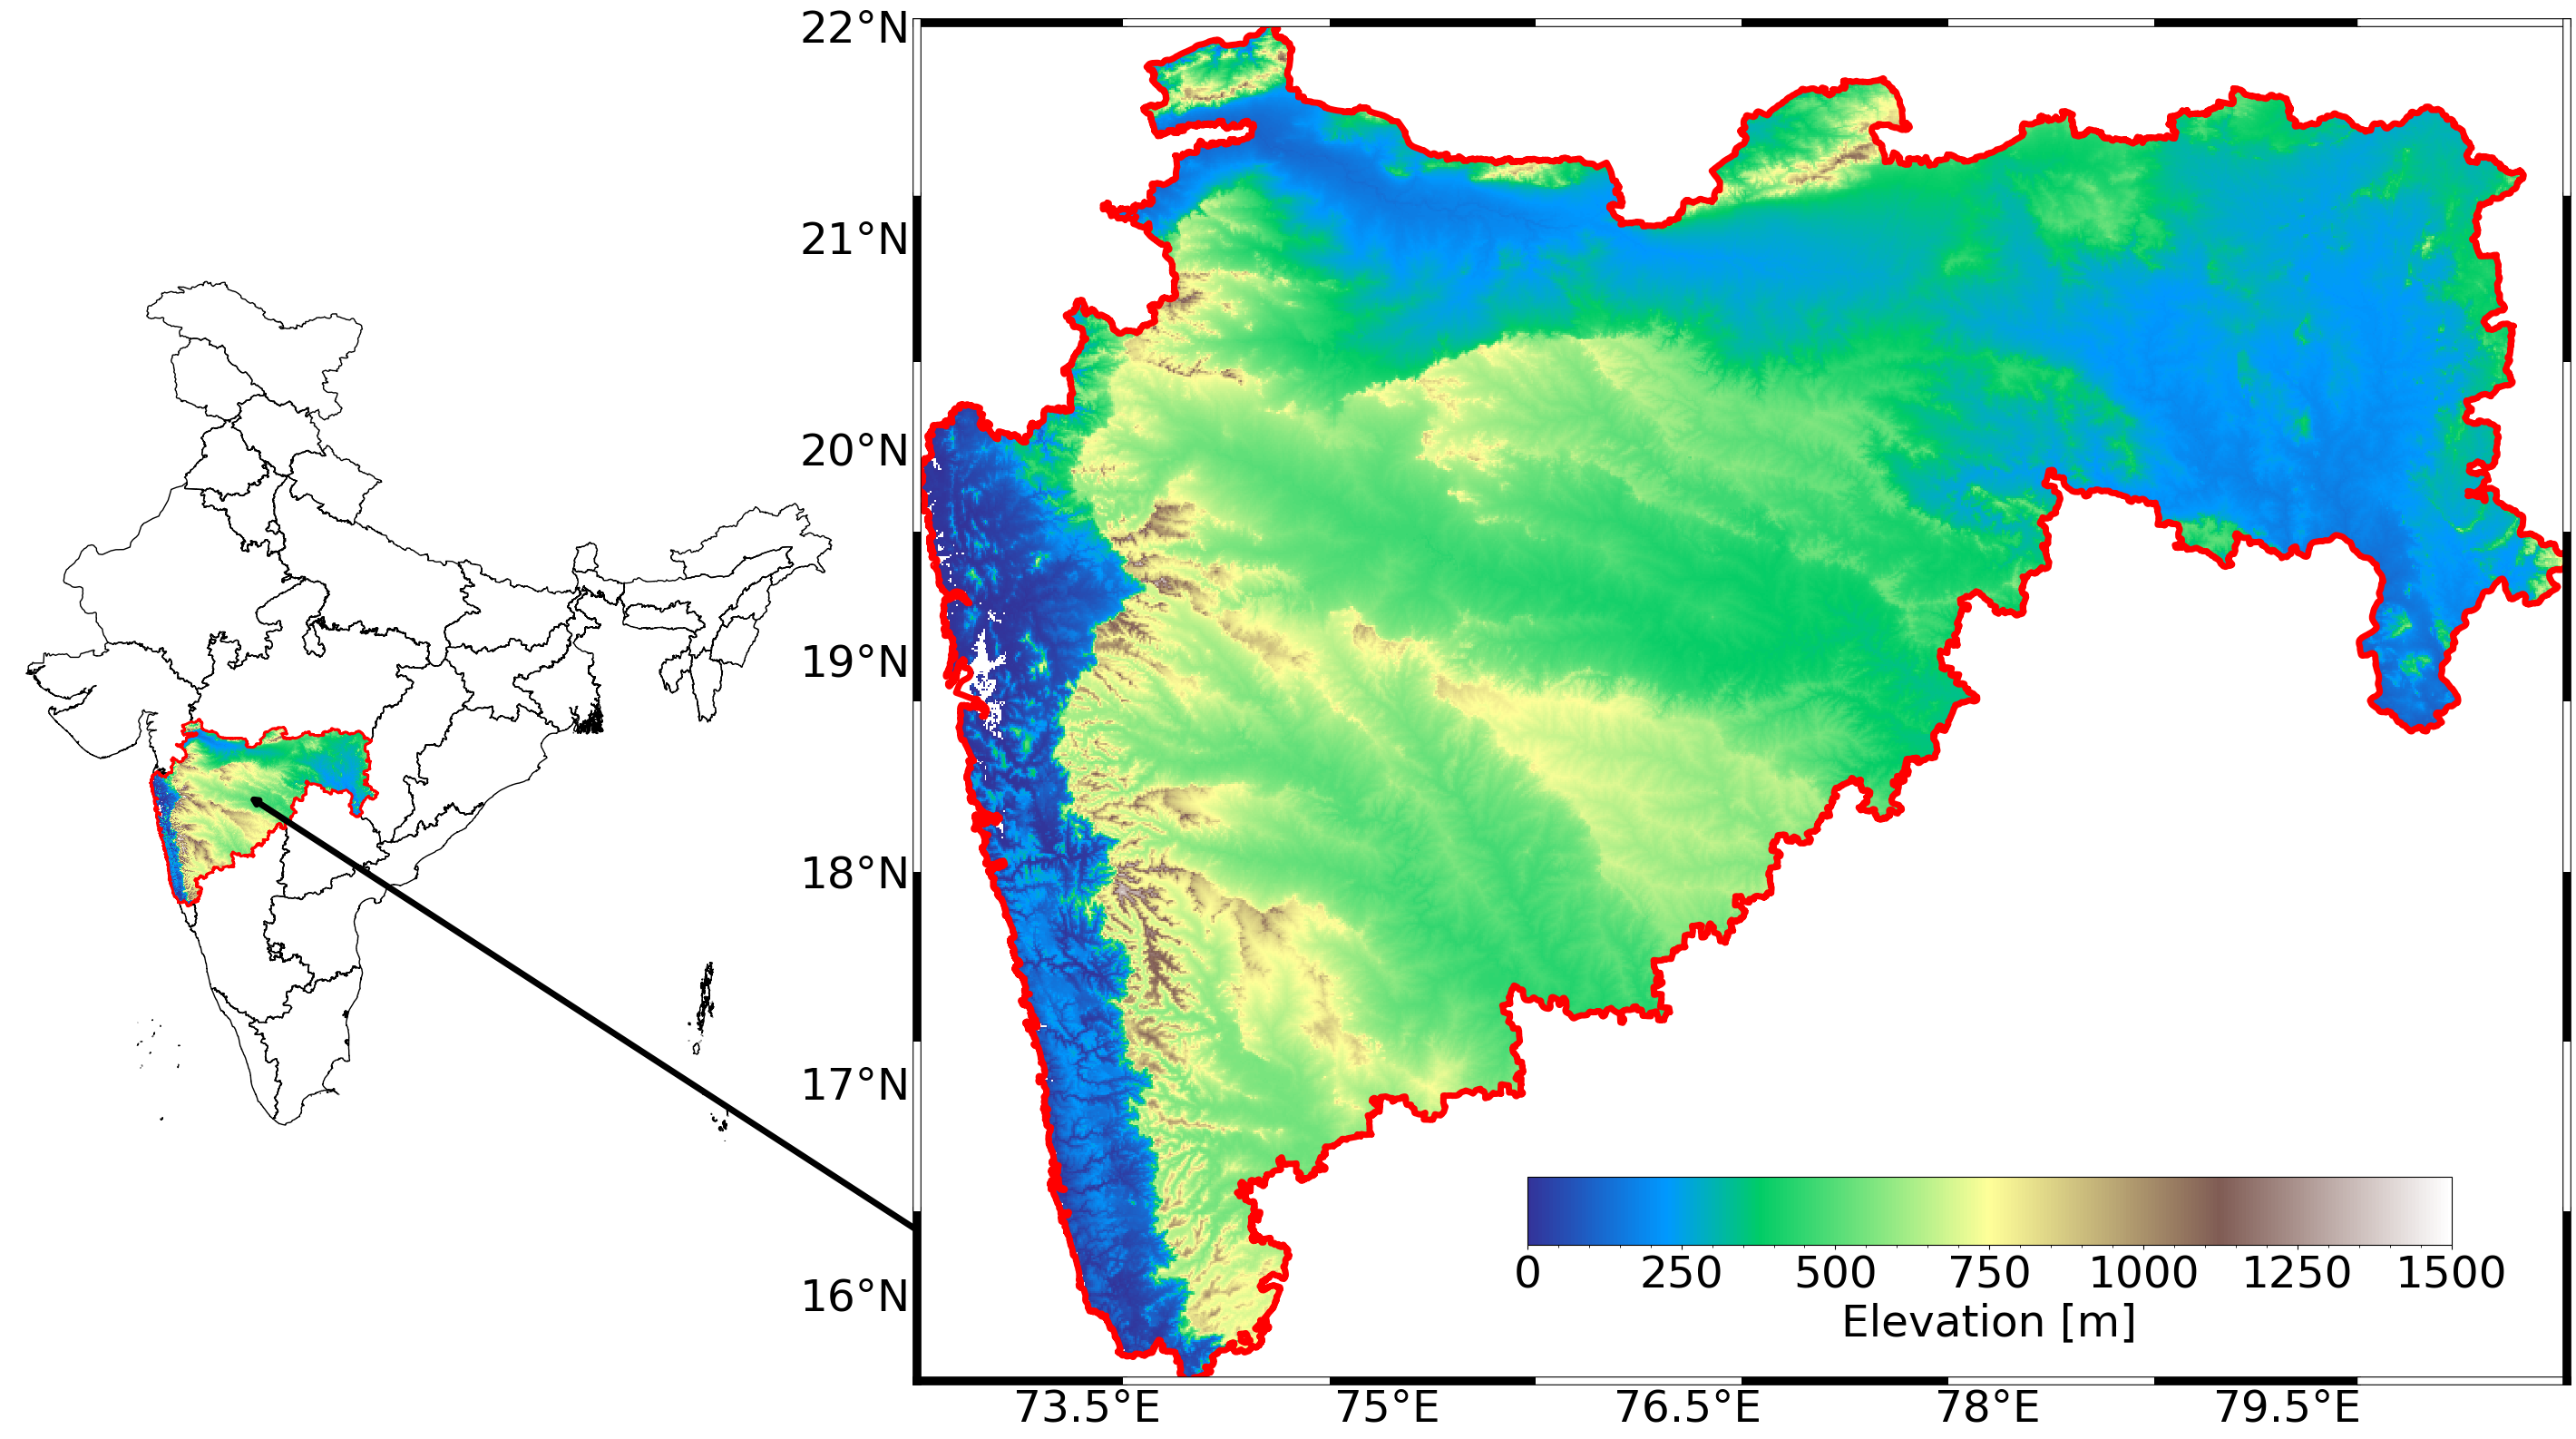

In [7]:
fig, axs = plt.subplots(subplot_kw=dict(
    projection=ccrs.PlateCarree()), figsize=[10, 10], tight_layout=True)
axs.set_extent([67.5, 97.5, 7.5, 37])
states.plot(ax=axs, fc='none', lw=1.0)
maha_raster.plot(ax=axs, cmap='terrain', add_colorbar=False, vmin=0, vmax=1200,)
axs.set_title("")
maha_map.plot(ax=axs, fc='none', ec='r', lw=2)
# add_map(axs, b=1, l=1, fontsize=15)
axs.axis('off')

axins = axs.inset_axes(
    [1.1, -0.5, 2, 2], xticklabels=[], yticklabels=[], projection=ccrs.PlateCarree())

subpl = maha_raster.plot.imshow(vmin=0, vmax=1500, cmap='terrain',
                                 add_colorbar=False, ax=axins, #cbar_kwargs={'label':'Alt [m]',}
                                 add_labels=False,)


# Add an inset axis for the colorbar inside axins (bottom side)
cb_ax = inset_axes(axins, width="80%", height="5%", loc='lower center', 
                   bbox_to_anchor=(0.3, 0.1, 0.7, 1),
                   bbox_transform=axins.transAxes, borderpad=0)

cbar = plt.colorbar(subpl, cax=cb_ax, orientation='horizontal')
cbar.set_label(label='Elevation [m]', fontsize=35)
cbar.ax.tick_params(labelsize=35)
cbar.ax.minorticks_on()



# caxins = plt.colorbar(subpl, ax=axins,
#                       fraction=0.1, shrink=0.5,
#                       location=('top'), anchor=(0.5, 1.8), ) #
# caxins.set_label(label='Elevation [m]', fontsize=18,)

# # Increase the font size of the tick labels
# caxins.ax.tick_params(labelsize=18)
# caxins.minorticks_on()

# import matplotlib.patches as mpatches
# import numpy as np
# import matplotlib.pyplot as plt

# # Elevation bins and labels
# elev_bins = [0, 100, 250, 500, 1000, 1500,]
# elev_labels = ["0", "100", "250", "500", "1000", "1500",]

# # Generate colors from the 'terrain' colormap
# cmap = plt.get_cmap('terrain')
# colors = cmap(np.linspace(0, 1, len(elev_labels)))  # use 0.2–1 to skip very light colors

# # Create Patch handles
# legend_handles = [
#     mpatches.Patch(color=colors[i], label=f"{elev_labels[i]} m", ec='k')
#     for i in range(len(elev_labels))
# ]

# # Add the discrete legend to the inset axis (or main axis if you prefer)
# axins.legend(
#     handles=legend_handles,
#     loc='lower right',
#     bbox_to_anchor=(1, 0),  # position to the right of inset
#     borderaxespad=0.2,
#     frameon=True,
#     title="Elevation in Meters",
#     fontsize=30,
#     title_fontsize=30
# )

# inset_indicator1 = axs.indicate_inset_zoom(axins, edgecolor="0", lw=3, zorder=0)
# inset_indicator1.connectors[0].set_visible(False)
# inset_indicator1.connectors[1].set_visible(False)
# inset_indicator1.connectors[2].set_visible(False)
# axins.set_aspect('equal')


# Get Maharashtra bounds
minx, miny, maxx, maxy = maha_map.total_bounds


# # Add custom lines for upper-left and lower-left only
# for (x, y) in [(minx, maxy), (minx, miny)]:  # UL and LL
#     con = ConnectionPatch(xyA=(x, y), coordsA=axs.transData,
#                           xyB=(x, y), coordsB=axins.transData,
#                           color='black', linewidth=2, zorder=20)
#     axs.add_artist(con)

# Single arrow from centroid
centroid = maha_map.geometry.centroid.iloc[0]
axs.annotate(
    '', xy=centroid.coords[0], xycoords='data',
    xytext=(1.1, -0.1), textcoords='axes fraction',  # roughly where the inset is
    arrowprops=dict(arrowstyle="->", color='black', lw=5)
)

# axins.set_aspect('equal')

maha_map.plot(ax=axins, fc='none', ec='r', lw=5)
axins.set_extent([minx, maxx, miny, maxy])
axins.zebra_frame(lw=7)
add_map(ax=axins, b=1, l=1, fontsize=35)
# plt.savefig("Maharashtra_Topo.png", bbox_inches='tight', dpi=600)
plt.savefig("Maharashtra_Topo.pdf", bbox_inches='tight', dpi=600)
plt.show()


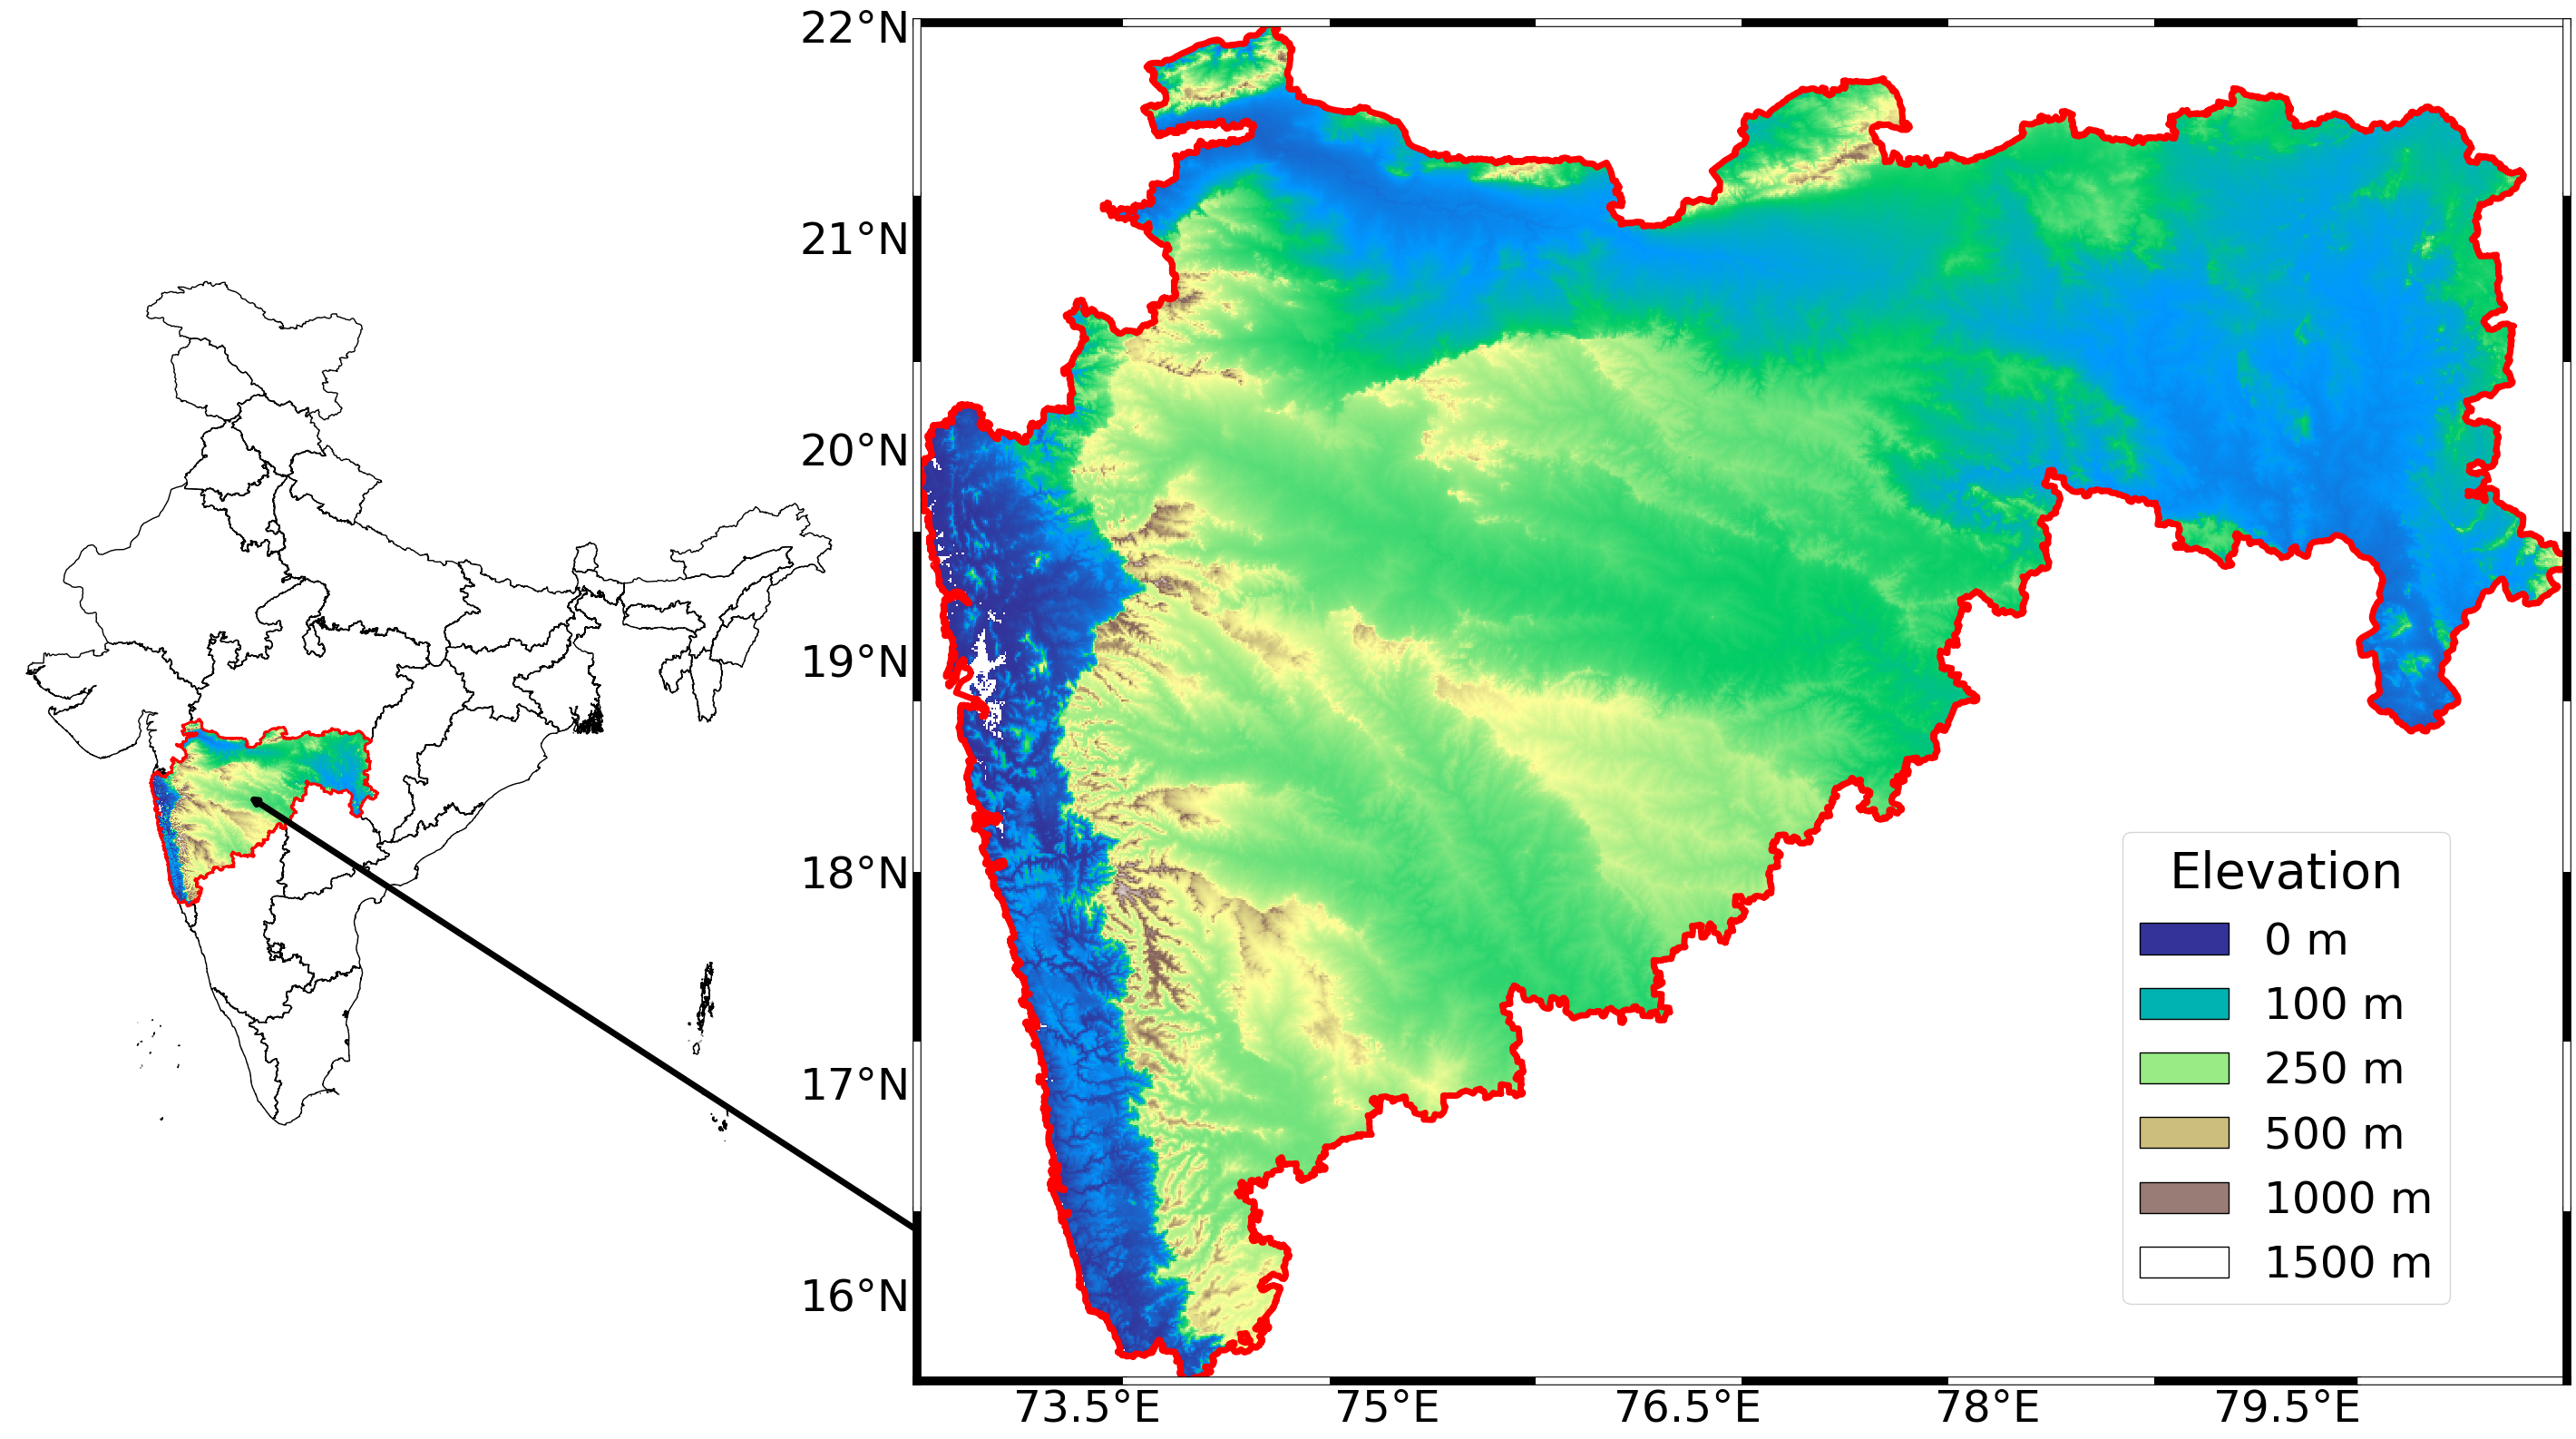

In [36]:
fig, axs = plt.subplots(subplot_kw=dict(
    projection=ccrs.PlateCarree()), figsize=[10, 10], tight_layout=True)
axs.set_extent([67.5, 97.5, 7.5, 37])
states.plot(ax=axs, fc='none', lw=1.0)
maha_raster.plot(ax=axs, cmap='terrain', add_colorbar=False, vmin=0, vmax=1200,)
axs.set_title("")
maha_map.plot(ax=axs, fc='none', ec='r', lw=2)
# add_map(axs, b=1, l=1, fontsize=15)
axs.axis('off')

axins = axs.inset_axes(
    [1.1, -0.5, 2, 2], xticklabels=[], yticklabels=[], projection=ccrs.PlateCarree())

subpl = maha_raster.plot.imshow(vmin=0, vmax=1500, cmap='terrain',
                                 add_colorbar=False, ax=axins, #cbar_kwargs={'label':'Alt [m]',}
                                 add_labels=False,)

import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt

# Elevation bins and labels
elev_bins = [0, 100, 250, 500, 1000, 1500,]
elev_labels = ["0", "100", "250", "500", "1000", "1500",]

# Generate colors from the 'terrain' colormap
cmap = plt.get_cmap('terrain')
colors = cmap(np.linspace(0, 1, len(elev_labels)))  # use 0.2–1 to skip very light colors

# Create Patch handles
legend_handles = [
    mpatches.Patch(color=colors[i], label=f"{elev_labels[i]} m", ec='k')
    for i in range(len(elev_labels))
]

# Add the discrete legend to the inset axis (or main axis if you prefer)
axins.legend(
    handles=legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.83, 0.05),  # position to the right of inset
    borderaxespad=0.2,
    frameon=True,
    title="Elevation",
    fontsize=35,
    title_fontsize=40
)

# Get Maharashtra bounds
minx, miny, maxx, maxy = maha_map.total_bounds


# Single arrow from centroid
centroid = maha_map.geometry.centroid.iloc[0]
axs.annotate(
    '', xy=centroid.coords[0], xycoords='data',
    xytext=(1.1, -0.1), textcoords='axes fraction',  # roughly where the inset is
    arrowprops=dict(arrowstyle="->", color='black', lw=5)
)

# axins.set_aspect('equal')

maha_map.plot(ax=axins, fc='none', ec='r', lw=5)
axins.set_extent([minx, maxx, miny, maxy])
axins.zebra_frame(lw=7)
add_map(ax=axins, b=1, l=1, fontsize=35)
plt.savefig("Maharashtra_Topo.png", bbox_inches='tight', dpi=600)
# plt.savefig("Maharashtra_Topo.pdf", bbox_inches='tight', dpi=600)
plt.show()
